In [1]:
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB

In [2]:
#导入库
import pandas as pd 
import numpy as np
import tushare as ts
import talib as tl
import joblib
import math
import matplotlib.pyplot as plt
import lightgbm as lgb
import sklearn.metrics
import optuna
from IPython.display import Image

#配置Tushare_pro
pro = ts.pro_api()

<font color='red' size=6> **基于LightGBM的 ${\alpha}$ 多因子择时策略** <font>

In [3]:
Image(url= ".\picture\流程图.png", width=800, height=1000)

#### **阿尔法多因子模型**
- 通过在做多个股的时候，根据${\beta}$反手做空股指期货，剥离大盘影响，锁定个股的${\alpha}$收益。

<font color='black' size=4>
\begin{aligned}
R_s&=r_f+{\alpha}+{\beta}(r_m-r_f)+{\epsilon_s}\\
{\alpha} &{\approx}R_s- {\beta}(r_m-r_f)-r_f   
\end{aligned}
</font>

- 通过个股择时获取${\alpha}$收益
- 构建因子池，与监督指标，利用机器学习方法（LightGBM+Optuna）,进行买点预测。




<font color='red' size=5> **STEP1 构造因子池** <font>

<font color='brown' size=4> **1 读取日线数据** <font>

In [4]:
#日线行情数据
start_time="20150904"
end_time="20200904"
ts_code='002049.SZ'

# df_daily = pro.daily(ts_code=ts_code, start_date=start_time, end_date=end_time)
# df_daily.to_csv('日线行情.csv')

df_daily=pd.read_csv('日线行情.csv',index_col=0)
df_daily.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,002049.SZ,20200904,121.48,128.50,121.00,124.42,123.30,1.12,0.9084,162123.27,2033883.581
1,002049.SZ,20200903,125.00,125.56,121.46,123.30,125.64,-2.34,-1.8625,121620.04,1499698.505
2,002049.SZ,20200902,128.96,128.98,124.50,125.64,128.22,-2.58,-2.0122,116487.38,1467161.225
3,002049.SZ,20200901,124.90,129.56,124.00,128.22,125.30,2.92,2.3304,156688.42,2001820.789
4,002049.SZ,20200831,129.00,129.40,125.30,125.30,127.69,-2.39,-1.8717,129152.12,1650964.628


<font color='brown' size=4> **2 构造技术分析指标** <font> 


In [5]:
Image(url= ".\picture\TA-Lib.png", 
      width=800, height=100)

In [9]:
#技术指标
df_tech=df_daily.copy(deep=True)
df_tech=df_tech.iloc[::-1]

#布林通道类
for days in [5,10,30,90,180,270,365]:
    for threshold in [1.5,2,2.5]:
        df_tech[f'BBANDS_{days}days_{threshold}STD_upper'],df_tech[f'BBANDS_{days}days_{threshold}STD_middle'],df_tech[f'BBANDS_{days}days_{threshold}STD_lower']=tl.BBANDS(df_tech['close'],nbdevup=threshold, nbdevdn=threshold,timeperiod=days)
#MA类
for days in [5,10,30,90,180,270,365]:
    df_tech[f'DEMA_{days}days']=tl.DEMA(df_tech['close'],timeperiod=days)
    df_tech[f'EMA_{days}days']=tl.EMA(df_tech['close'],timeperiod=days)
    df_tech[f'SMA_{days}days']=tl.SMA(df_tech['close'],timeperiod=days)
    df_tech[f'KAMA_{days}days']=tl.KAMA(df_tech['close'],timeperiod=days)
    df_tech[f'WMA_{days}days']=tl.WMA(df_tech['close'],timeperiod=days)
    df_tech[f'TRIMA_{days}days']=tl.TRIMA(df_tech['close'],timeperiod=days)
    
#Momentum类
for days in [5,10,30,90,180,270,365]:   
    df_tech[f'ADX_{days}days']=tl.ADX(df_tech['high'],df_tech['low'],df_tech['close'],timeperiod=days)
    df_tech[f'ADXR_{days}days']=tl.ADX(df_tech['high'],df_tech['low'],df_tech['close'],timeperiod=days)
    df_tech[f'AROONOSC_{days}days']=tl.AROONOSC(df_tech['high'],df_tech['low'],timeperiod=days)
    df_tech[f'DX_{days}days']=tl.DX(df_tech['high'],df_tech['low'],df_tech['close'],timeperiod=days)
    df_tech[f'MFI_{days}days']=tl.MFI(df_tech['high'],df_tech['low'],df_tech['close'],df_tech['vol'],timeperiod=days)
    df_tech[f'MOM_{days}days']=tl.MOM(df_tech['close'],timeperiod=days)
    df_tech[f'RSI_{days}days']=tl.RSI(df_tech['close'],timeperiod=days)
    df_tech[f'WILLR_{days}days']=tl.WILLR (df_tech['high'],df_tech['low'],df_tech['close'],timeperiod=days)

df_tech[f'MACD_macd'],df_tech[f'MACD_macdsignal'],df_tech[f'MACD_macdhist']=tl.MACD(df_tech['close'])
df_tech[f'MAMA_mama'],df_tech[f'MAMA_fama']=tl.MAMA(df_tech['close'])
df_tech[f'HT_TRENDLINE']=tl.HT_TRENDLINE(df_tech['close'])
df_tech[f'SAR']=tl.SAR (df_tech['high'],df_tech['low'])
df_tech[f'SAREXT']=tl.SAR (df_tech['high'],df_tech['low'])
df_tech[f'ULTOSC']=tl.ULTOSC(df_tech['high'],df_tech['low'],df_tech['close'])
df_tech[f'BOP']=tl.BOP(df_tech['open'],df_tech['high'],df_tech['low'],df_tech['close'])
df_tech[f'APO']=tl.APO(df_tech['close'])
df_tech[f'PPO']=tl.PPO(df_tech['close'])

#Pattern Recognition类
for func in tl.get_function_groups()['Pattern Recognition']:
    if abs(eval('tl.'+func)(df_tech['open'],df_tech['high'],df_tech['low'],df_tech['close']).sum())>10000:#至少出现100次的形态 否则太过稀疏 不可取
        df_tech[func]=eval('tl.'+func)(df_tech['open'],df_tech['high'],df_tech['low'],df_tech['close'])
df_tech.to_csv('技术分析.csv')
df_tech.iloc[200:210,80:100]

,DEMA_10days,EMA_10days,SMA_10days,KAMA_10days,WMA_10days,TRIMA_10days,DEMA_30days,EMA_30days,SMA_30days,KAMA_30days,WMA_30days,TRIMA_30days,DEMA_90days,EMA_90days,SMA_90days,KAMA_90days,WMA_90days,TRIMA_90days,DEMA_180days,EMA_180days
824,36.475219,36.672301,36.833,36.869345,36.641818,36.878000,36.352156,37.008552,36.646667,38.006767,36.746151,36.695708,36.514551,38.575616,39.332889,38.147075,37.911324,38.938406,NaN,40.602508
823,36.553266,36.695519,36.772,36.867088,36.635818,36.767667,36.368463,36.995097,36.608333,37.989554,36.756043,36.741750,36.482657,38.536591,39.280000,38.128710,37.855656,38.843604,NaN,40.560492
822,36.382265,36.587243,36.677,36.827390,36.513636,36.643333,36.297120,36.937349,36.616667,37.978074,36.723247,36.785167,36.421873,38.483040,39.187778,38.077218,37.785766,38.749232,NaN,40.511204
821,36.274990,36.507744,36.562,36.776637,36.417818,36.524000,36.240109,36.886552,36.620667,37.968849,36.693140,36.813583,36.365749,38.431764,39.104222,38.032967,37.719001,38.657188,NaN,40.463014
820,36.129625,36.404518,36.478,36.731171,36.304727,36.433000,36.163619,36.825485,36.622000,37.959830,36.649226,36.828333,36.302831,38.377000,39.017000,37.982559,37.649458,38.566932,NaN,40.413036
819,35.933484,36.269151,36.333,36.591970,36.156000,36.340333,36.060786,36.750292,36.602667,37.938643,36.587161,36.830792,36.230301,38.317286,38.941000,37.933670,37.575678,38.478478,NaN,40.360516
818,35.846035,36.187487,36.201,36.511640,36.062727,36.240000,35.989105,36.690273,36.583667,37.919358,36.536667,36.823667,36.167605,38.262401,38.868667,37.891521,37.507084,38.391164,NaN,40.310345
817,35.578369,36.006126,36.041,36.348577,35.878909,36.120667,35.847002,36.593481,36.546000,37.878184,36.446753,36.804542,36.080078,38.194875,38.763778,37.804487,37.426234,38.303580,NaN,40.253767
816,35.571473,35.959557,35.990,36.334176,35.826000,36.011000,35.789837,36.539063,36.521000,37.856045,36.395398,36.775917,36.020271,38.141142,38.662111,37.741347,37.359998,38.216783,NaN,40.204001
815,35.632263,35.954183,35.970,36.330173,35.815091,35.904667,35.762120,36.499769,36.477667,37.822188,36.357269,36.740417,35.970758,38.092545,38.565111,37.688783,37.299951,38.131585,NaN,40.156775


<font color='brown' size=4> **3 构造基本面财务指标** <font> 

In [10]:
#财务基本面指标

# df_incomestatement = pro.income(ts_code=ts_code, start_date=start_time, end_date=end_time)
# df_balancesheet = pro.balancesheet(ts_code=ts_code, start_date=start_time, end_date=end_time)
# df_cashflow = pro.cashflow(ts_code=ts_code, start_date=start_time, end_date=end_time)
# df_financial_ratio = pro.fina_indicator(ts_code=ts_code, start_date=start_time, end_date=end_time)
# df_incomestatement.to_csv('incomestatement.csv')
# df_balancesheet.to_csv('balancesheet.csv')
# df_cashflow.to_csv('cashflow.csv')
# df_financial_ratio.to_csv('financial_ratio.csv')

df_incomestatement=pd.read_csv('incomestatement.csv',index_col=0)
df_balancesheet=pd.read_csv('balancesheet.csv',index_col=0)
df_cashflow=pd.read_csv('cashflow.csv',index_col=0)
df_financial_ratio=pd.read_csv('financial_ratio.csv',index_col=0)
df_financial_ratio.head()

,ts_code,ann_date,end_date,eps,dt_eps,total_revenue_ps,revenue_ps,capital_rese_ps,surplus_rese_ps,undist_profit_ps,...,ocf_yoy,roe_yoy,bps_yoy,assets_yoy,eqt_yoy,tr_yoy,or_yoy,q_sales_yoy,q_op_qoq,equity_yoy
0,002049.SZ,20200820,20200630,0.6624,0.6624,2.4132,2.4132,1.0201,0.2042,5.2424,...,-44.7829,82.0548,8.5889,7.5114,8.5879,-6.0754,-6.0754,-8.0380,9.8127,14.5098
1,002049.SZ,20200424,20200331,0.3132,0.3132,1.0645,1.0645,1.0201,0.2042,4.9613,...,9.2781,150.5415,4.5190,6.3604,4.5183,-3.4651,-3.4651,-3.4651,289.2080,13.1209
2,002049.SZ,20200402,20191231,0.6687,0.6687,5.6531,5.6531,1.0201,0.2042,4.6557,...,-16.5433,5.6418,10.3792,11.7561,10.3796,39.5370,39.5370,25.9262,-71.5294,10.3796
3,002049.SZ,20191024,20190930,0.6016,0.6016,4.1017,4.1017,1.0201,0.1943,4.5985,...,-126.8230,14.8847,9.3669,11.7900,9.3670,45.4845,45.4845,41.3827,32.3841,10.4390
4,002049.SZ,20190822,20190630,0.3177,0.3177,2.5693,2.5693,1.0201,0.1943,4.3146,...,-103.7205,49.0196,4.6714,4.6576,4.6713,48.0463,48.0463,65.5464,97.6638,8.0526


<font color='brown' size=4> **4 构造宏观经济指标** <font> 

In [11]:
#利率数据
# df_shibor = pro.shibor(start_date=start_time, end_date=end_time)
# df_shibor.to_csv('shibor.csv')
df_shibor=pd.read_csv('shibor.csv',index_col=0)
df_shibor.columns=['ann_date', 'shibor_on', 'shibor_1w', 'shibor_2w', 'shibor_1m', 'shibor_3m', 'shibor_6m', 'shibor_9m', 'shibor_1y']
df_shibor.head()

,ann_date,shibor_on,shibor_1w,shibor_2w,shibor_1m,shibor_3m,shibor_6m,shibor_9m,shibor_1y
0,20200903,1.742,2.197,2.187,2.390,2.654,2.863,2.914,2.951
1,20200902,2.094,2.201,2.226,2.380,2.646,2.852,2.905,2.945
2,20200901,2.104,2.211,2.242,2.372,2.640,2.847,2.901,2.942
3,20200831,1.766,2.228,2.349,2.374,2.636,2.844,2.893,2.933
4,20200828,1.345,2.235,2.338,2.366,2.630,2.834,2.883,2.922


<font color='brown' size=4> **5 合并所有因子** <font> 

In [12]:
#合并表
from functools import reduce 
df_others=[df_incomestatement,df_balancesheet,df_cashflow,df_financial_ratio,df_shibor]
for df_reindex in df_others:
    df_reindex=df_reindex.iloc[::-1]
    
df=[df_tech,df_incomestatement,df_balancesheet,df_cashflow,df_financial_ratio,df_shibor]
df_merge= reduce(lambda left,right: pd.merge(left,right,left_on='trade_date',right_on='ann_date',how="left"), df)

df_merge.drop_duplicates(subset='trade_date',inplace=True)

#消去带有时间的列
df_cleaned=df_merge.copy(deep=True)
df_cleaned.index=df_merge['trade_date'].values

remove_columns=list(df_merge.columns[df_merge.columns.str.contains("date")])
remove_columns=remove_columns+['ts_code_x','ts_code_y','ts_code']
df_cleaned.drop(columns=remove_columns,inplace=True)

df_cleaned.head()

,open,high,low,close,pre_close,change,pct_chg,vol,amount,BBANDS_5days_1.5STD_upper,...,q_op_qoq,equity_yoy,shibor_on,shibor_1w,shibor_2w,shibor_1m,shibor_3m,shibor_6m,shibor_9m,shibor_1y
20150907,32.12,34.19,28.83,29.05,32.03,-2.98,-9.30,193163.03,583415.7524,NaN,...,NaN,NaN,1.9040,2.410,2.945,3.040,3.099,3.2739,3.3072,3.4010
20150908,28.94,30.88,27.98,30.50,29.05,1.45,4.99,86388.16,252918.7549,NaN,...,NaN,NaN,1.8970,2.402,2.724,3.018,3.095,3.2880,3.3112,3.4090
20150909,30.55,32.68,29.84,32.30,30.50,1.80,5.90,235614.20,731729.0810,NaN,...,NaN,NaN,1.8960,2.398,2.650,3.010,3.092,3.3010,3.3146,3.4143
20150910,31.30,32.26,30.70,31.18,32.30,-1.12,-3.47,100430.53,317636.4290,NaN,...,NaN,NaN,1.8990,2.400,2.616,3.008,3.093,3.3020,3.3180,3.4100
20150911,31.25,32.33,31.18,31.75,31.18,0.57,1.83,79837.96,253776.0500,32.643446,...,NaN,NaN,1.9001,2.403,2.641,3.005,3.097,3.3110,3.3235,3.4110


<font color='red' size=5> **STEP3 构造监督指标** <font>

<font color='brown' size=4> **1 计算不同时间窗口与收益率组合构成监督指标的正负比例** <font> 

In [13]:
dfy_origin=pd.DataFrame(data=df_cleaned['close'],index=df_cleaned.index)

#定义apply的函数
def find_signal(column,time_window,return_ratio):
    
    signal_column=np.zeros(len(column))
    
    for i in range(len(column)-time_window):
        for search in range(1,time_window+1):
            if (column[i+search]/column[i]-1)>return_ratio:
                signal_column[i]=1
                
    signal_percent=signal_column.sum()/dfy_origin.shape[0]
    return signal_column,signal_percent

#计算不同时间窗口，收益率下的 label 以及正负样本比例
time_window_list=[]
return_ratio_list=[]
singal_list=[]
signal_percent_list=[]

for time_window in [1,3,7,14,30,60,90,180]:
    for return_ratio in [0.005,0.01,0.02,0.03,0.05,0.1,0.15,0.2]:     
        signal,signal_percent=find_signal(dfy_origin['close'].values,time_window,return_ratio)
        time_window_list.append(time_window)
        return_ratio_list.append(return_ratio)
        singal_list.append(signal)
        signal_percent_list.append(signal_percent)
        
df_find_signal=pd.DataFrame({'time_period':time_window_list,'return_ratio':return_ratio_list,'signal':singal_list,'signal_percent':signal_percent_list})
df_find_signal.to_csv("label指标选取.csv")

<font color='brown' size=4
      > **2 选取正负样本比较均衡的标签** <font> 

In [14]:
#筛选正负样本比较均衡的df_cleaned内的label
dfy=pd.DataFrame()

for row in df_find_signal.iterrows():
    if abs(row[1][3]-0.5)<0.03: #选取正负比例低于3%
        dfy[f"flag_{row[1][0]}days_{row[1][1]}"]=row[1][2]
        
dfy.index=dfy_origin.index
dfy

,flag_7days_0.03,flag_14days_0.05,flag_30days_0.1,flag_60days_0.15
20150907,1.0,1.0,1.0,1.0
20150908,1.0,1.0,1.0,1.0
20150909,0.0,0.0,1.0,1.0
20150910,0.0,0.0,1.0,1.0
20150911,0.0,0.0,1.0,1.0
...,...,...,...,...
20200831,0.0,0.0,0.0,0.0
20200901,0.0,0.0,0.0,0.0
20200902,0.0,0.0,0.0,0.0
20200903,0.0,0.0,0.0,0.0


<font color='red' size=5> **STEP4 特征工程及数据切分** <font>

<font color='brown' size=4> **1 处理全空列并填充** <font> 

In [15]:
#删除全空的数据
drop_null=[]

for column in df_cleaned.columns:
    null_num=df_cleaned[column].isnull().sum()
    if null_num==df_cleaned.shape[0]:
        drop_null.append(column)
        
df_drop_null=df_cleaned.drop(columns=drop_null)

#先前值填充 主要填财务数据 
df_filled=df_drop_null.fillna(method='ffill')
#前值填充完毕之后 后值填充 主要填充技术分析数据
df_filled=df_filled.fillna(method='bfill')
df_filled.head()

,open,high,low,close,pre_close,change,pct_chg,vol,amount,BBANDS_5days_1.5STD_upper,...,q_op_qoq,equity_yoy,shibor_on,shibor_1w,shibor_2w,shibor_1m,shibor_3m,shibor_6m,shibor_9m,shibor_1y
20150907,32.12,34.19,28.83,29.05,32.03,-2.98,-9.30,193163.03,583415.7524,32.643446,...,-48.9886,9.8895,1.9040,2.410,2.945,3.040,3.099,3.2739,3.3072,3.4010
20150908,28.94,30.88,27.98,30.50,29.05,1.45,4.99,86388.16,252918.7549,32.643446,...,-48.9886,9.8895,1.8970,2.402,2.724,3.018,3.095,3.2880,3.3112,3.4090
20150909,30.55,32.68,29.84,32.30,30.50,1.80,5.90,235614.20,731729.0810,32.643446,...,-48.9886,9.8895,1.8960,2.398,2.650,3.010,3.092,3.3010,3.3146,3.4143
20150910,31.30,32.26,30.70,31.18,32.30,-1.12,-3.47,100430.53,317636.4290,32.643446,...,-48.9886,9.8895,1.8990,2.400,2.616,3.008,3.093,3.3020,3.3180,3.4100
20150911,31.25,32.33,31.18,31.75,31.18,0.57,1.83,79837.96,253776.0500,32.643446,...,-48.9886,9.8895,1.9001,2.403,2.641,3.005,3.097,3.3110,3.3235,3.4110


<font color='brown' size=4> **2 按照比例切分数据集** <font> 

In [16]:
def split_data(dfx,dfy,train_percentage,val_percentage):
    
    train_x,train_y=dfx.iloc[:round(train_percentage*dfx.shape[0]),:],dfy.iloc[:round(train_percentage*dfy.shape[0]),:]
    val_x,val_y=dfx.iloc[train_x.shape[0]:train_x.shape[0]+round(val_percentage*dfx.shape[0]),:],dfy.iloc[train_y.shape[0]:train_y.shape[0]+round(val_percentage*dfy.shape[0]),:]
    forecast_x,forecast_y=dfx.iloc[val_x.shape[0]+train_x.shape[0]:,:],dfy.iloc[val_y.shape[0]+train_y.shape[0]:,:]
    
    #转换成lgb需要的格式
    train_y=train_y.astype('float')
    train_x=train_x.astype('float')
    val_y=val_y.astype('float')
    val_x=val_x.astype('float')
    forecast_y=forecast_y.astype('float')
    forecast_x=forecast_x.astype('float')
    
    return train_x,train_y,val_x,val_y,forecast_x,forecast_y

In [17]:
train_x,train_y,val_x,val_y,forecast_x,forecast_y=split_data(df_filled,dfy,train_percentage=0.6,val_percentage=0.2)
forecast_start_time=forecast_x.index[0]

<font color='red' size=5> **STEP5 构建模型 调整超参数** <font>

In [18]:
Image(url= ".\picture\LightGBM.png", 
      width=500, height=100)

In [19]:
Image(url= ".\picture\Optuna.png", 
      width=500, height=100)

<font color='brown' size=4> **1 定义超参数调整框架** <font> 

In [20]:
def objective(trial):

    dtrain = lgb.Dataset(train_x, label=train_y[train_y.columns[1]])
    valid_y=val_y[val_y.columns[1]]

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(val_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    
    return accuracy

In [21]:
# %%time
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)
# joblib.dump(study,'14_days_0.05_return_40%.pkl')
study=joblib.load('14_days_0.05_return_40%.pkl')
print(study.best_value)

0.6215686274509804


<font color='brown' size=4> **2 预测并输出结果** <font> 

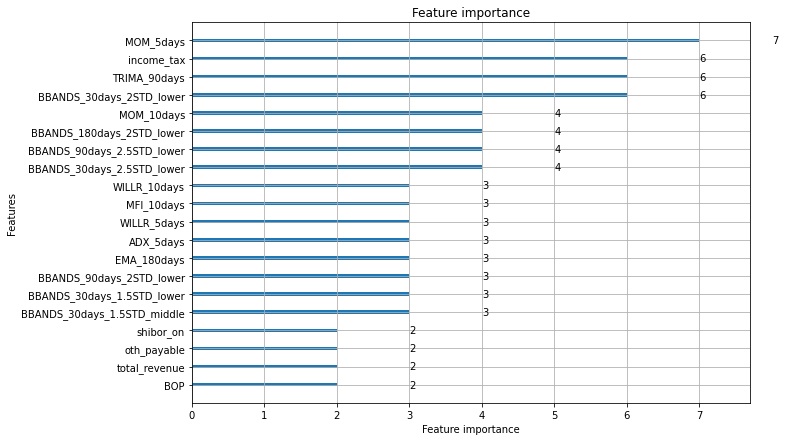

In [22]:
#预测并输出信号
dtrain = lgb.Dataset(train_x, label=train_y[train_y.columns[0]])
valid_y=val_y[val_y.columns[0]]
param=study.best_params

gbm = lgb.train(param, dtrain)
preds = gbm.predict(forecast_x)
pred_labels = abs(np.rint(preds))

#可视化特征重要性图
lgb.plot_importance(gbm,max_num_features=20,figsize=(10,7))

In [23]:
#得到交易信号
# df_signal=pd.DataFrame(pred_labels,index=forecast_x.index,columns=['signal'])
# df_signal.to_csv('singnal.csv')
df_signal=pd.read_csv('singnal.csv',index_col=0)
df_signal

,signal
20191105,0.0
20191106,1.0
20191107,1.0
20191108,1.0
20191111,1.0
...,...
20200831,0.0
20200901,0.0
20200902,0.0
20200903,0.0


<font color='red' size=6> **STEP6 计算个股和股指期货的配比** <font>

#### **${\beta}$与资金管理**
- 对于多因子${\alpha}$策略来说，要通过构建${\beta}$值为0的投资组合，对冲掉系统性风险,让个股收益仅仅和${\alpha}$有关。

<font color='black' size=4>
\begin{aligned}
R_s&=r_f+{\alpha}+0{\times}(r_m-r_f)+{\epsilon_s}\\
{\beta_{portfolio}}&=W_{stock}{\times}{\beta_{stock}}+W_{index}{\times}{\beta_{index}}
\end{aligned}
</font>

- 根据策略${\beta_{portfolio}}$=0，做空股指${\beta_{index}}$=-1

<font color='black' size=4>
\begin{aligned}
0&=W_{stock}{\times}{\beta_{stock}}+W_{index}{\times}(-1)
\end{aligned}
</font>

- 由此得到股指与个股的资金配比
<font color='black' size=4>
\begin{aligned}
\frac{W_{index}}{W_{stock}}&={\beta_{stock}}
\end{aligned}
</font>



<font color='brown' size=4> **1 获取相关数据** <font> 

In [24]:
#读取沪深300 指数
# df_index = pro.index_daily(ts_code='399300.SZ',start_date=start_time,end_date=end_time)
# df_index.to_csv("沪深300数据.csv")
df_index=pd.read_csv("沪深300数据.csv",index_col=0)

df_index.index=df_index['trade_date'].values
df_daily_cal=df_daily.loc[::-1]
df_index=df_index.iloc[::-1]
df_index['return_market']=[math.log(x/y) for x,y in zip(df_index['close'],df_index['pre_close'])]
df_daily_cal['return_stock']=[math.log(x/y) for x,y in zip(df_daily_cal['close'],df_daily_cal['pre_close'])]

D:\python\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<font color='brown' size=4> **2 计算${\beta}$值及持仓比** <font> 

In [25]:
#拼接表格 计算beta需要的东西
df_job=df_index.merge(df_daily_cal,how='outer',on='trade_date')
df_job.index=df_job['trade_date']
df_job.fillna(method="ffill")
df_job=df_job.loc[:forecast_start_time]

std_stock=math.sqrt(df_job['return_stock'].var(ddof=1))
std_market=math.sqrt(df_job['return_market'].var(ddof=1))
corr=df_job.corr().loc['return_stock','return_market']

#计算beta值
beta=corr*std_stock/std_market
pd.DataFrame({'std_stock':std_stock,'std_market':std_market,'corr':corr,'beta':beta,'stock_position':1/(1+beta),'index_position':beta/(1+beta)},index=['Values'])

,std_stock,std_market,corr,beta,stock_position,index_position
Values,0.034251,0.012791,0.436993,1.170099,0.460808,0.539192


<font color='red' size=6> **STEP7 根据输出的买点信号 构建交易系统** <font>

<font color='brown' size=4> **1 根据信号 整合表** <font> 

In [26]:
#把股票数据 股指数据 交易信号整合起来
df_back_test=pd.merge(df_cleaned['close'],df_index['close'],validate="one_to_one",left_on=df_cleaned.index,right_on=df_index.index,how='inner')
df_back_test.index=df_back_test.key_0.values
df_back_test.drop(columns=['key_0'],inplace=True)
df_back_test.columns=["stock_close","index_close"]
df_back_test=df_back_test.loc[forecast_start_time:]

df_back_test['buy_signal']=df_signal[df_signal.columns[0]]
df_back_test.to_csv('信号整合结果.csv')
df_back_test.head()

,stock_close,index_close,buy_signal
20191105,52.20,4002.8128,0.0
20191106,46.98,3984.8816,1.0
20191107,47.42,3991.8749,1.0
20191108,47.50,3973.0107,1.0
20191111,45.14,3902.9783,1.0


<font color='brown' size=4> **2 初始化交易系统** <font> 

In [27]:
#初始化交易系统
cash=100000                                        #总现金
stock_weight=1/(beta+1)                             #股票配比
index_weight=beta/(beta+1)                         #指数期货配比
    
stock_position=0                                    #股票仓位
index_position=0                                    #指数期货仓位

asset=stock_position+index_position+cash            #总资产

asset_list=[]                                       #总资产存放列表
stock_list=[]                                       #股票资产存放列表
index_list=[]                                       #股指资产存放列表
buy_time_list=[]                                    #储存真实买点

last_buy_time=df_back_test.index[0]

<font color='brown' size=4> **3 回测 模拟真实交易** <font> 

In [28]:
#构建交易系统
for i in df_back_test.index:
    
    if stock_position==0:
        
        if df_back_test.loc[i,'buy_signal']==1 :
            
            stock_position=stock_weight*asset   
            index_position=index_weight*asset       
            
            cash=0                                       
            asset=stock_position+index_position+cash
            
            last_buy_time=i                  #标记买点的时间
            buy_time_list.append(i)
            
            asset_last=asset                 #标记买点产品净值
            stock_last=stock_position        #标记买点股票净值
            index_last=index_position        #标记买点指数净值
            
            stock_price=df_back_test.loc[i,'stock_close']
            index_price=df_back_test.loc[i,'index_close']
            
            print(f'出现买点 买入 日期：{i} 股票价格：{stock_price} 股指价格：{index_price} 当前资产：{asset}') 
            
        else:
            asset=stock_position+index_position+cash

    else:
        stock_change=df_back_test.loc[i,'stock_close']/df_back_test.loc[last_buy_time,'stock_close']-1
        index_change=df_back_test.loc[i,'index_close']/df_back_test.loc[last_buy_time,'index_close']-1
        return_rate=stock_change*stock_weight-index_change*index_weight
       
        stock_position=stock_last*(stock_change+1)  #当前股票净值为变化率乘以上次买入时净值
        index_position=index_last*(-index_change+1) #当前指数净值为变化率乘以上次买入时净值
        
        asset=(stock_position+index_position+cash)*(1-2.5/10000)  #假设万2.5的交易手续费

        if return_rate>=0.05 or return_rate<=-0.1:                #收益率超过5%就卖出
            
            if return_rate<=-0.2:
                print(f'亏损超过10% 止损 日期：{i} 本次亏损率：{return_rate}')                                     #投放止损信号
                
            cash=asset
            stock_position=0
            index_position=0
            
            stock_price=df_back_test.loc[i,'stock_close']
            index_price=df_back_test.loc[i,'index_close']
            print(f'出现卖点 卖出 日期：{i} 股票价格：{stock_price} 股指价格：{index_price} 当前资产：{asset} 本次收益率：{return_rate:.2%} 累计收益率：{asset/asset_list[0]-1:.2%}') 
            
    #储存历史仓位值
    asset_list.append(asset)
    stock_list.append(stock_position)
    index_list.append(index_position)

出现买点 买入 日期：20191106 股票价格：46.98 股指价格：3984.8816 当前资产：99999.99999999999
出现卖点 卖出 日期：20191225 股票价格：53.1 股指价格：3990.8671 当前资产：105895.39851216252 本次收益率：5.92% 累计收益率：5.90%
出现买点 买入 日期：20200203 股票价格：50.26 股指价格：3688.3578 当前资产：105895.3985121625
出现卖点 卖出 日期：20200219 股票价格：64.07 股指价格：4051.3107 当前资产：113656.40188575431 本次收益率：7.36% 累计收益率：13.66%
出现买点 买入 日期：20200312 股票价格：54.54 股指价格：3950.9111 当前资产：113656.40188575428
出现卖点 卖出 日期：20200318 股票价格：55.55 股指价格：3636.2565 当前资产：119477.01774389017 本次收益率：5.15% 累计收益率：19.48%
出现买点 买入 日期：20200325 股票价格：52.78 股指价格：3722.5181 当前资产：119477.01774389014
出现卖点 卖出 日期：20200403 股票价格：58.75 股指价格：3713.2183 当前资产：125833.93403792841 本次收益率：5.35% 累计收益率：25.83%
出现买点 买入 日期：20200424 股票价格：55.8 股指价格：3796.9721 当前资产：125833.93403792838
出现卖点 卖出 日期：20200512 股票价格：68.53 股指价格：3960.2378 当前资产：136111.0358268611 本次收益率：8.19% 累计收益率：36.11%
出现买点 买入 日期：20200611 股票价格：64.58 股指价格：3995.8846 当前资产：136111.03582686107
出现卖点 卖出 日期：20200701 股票价格：80.03 股指价格：4247.7835 当前资产：146453.22622024867 本次收益率：7.63% 累计收益率：46.45%
出现买点 买入 日期：20200

In [29]:
#构建基础指标 沪深300净值
asset_index_start=100000
index_price=df_index.loc[forecast_start_time:,'close']
index_asset_list=[]

for day in index_price.index:
    index_return=index_price.loc[day]/index_price.iloc[0]-1
    asset_index=asset_index_start*(1+index_return)
    index_asset_list.append(asset_index)

In [30]:
#计算相关收益率

#1.策略收益率
stock_return_ratio=asset_list[-1]/asset_list[0]-1
index_return_ratio=index_asset_list[-1]/index_asset_list[0]-1

r_0=df_cleaned['shibor_1y'].loc[forecast_start_time:].mean()   #同期shibor平均收益率

stock_return_ratio_year=stock_return_ratio/len(asset_list)*356
index_return_ratio_year=index_return_ratio/len(index_asset_list)*356

#2.Sharpe Ratio
stock_daily_return=np.array([x/asset_list[0] for x in asset_list]) #计算策略日收益率
index_daily_return=np.array([x/index_asset_list[0] for x in index_asset_list]) 

stock_sp_ratio=(stock_return_ratio-r_0/100)/math.sqrt(stock_daily_return.var())
index_sp_ratio=(index_return_ratio-r_0/100)/math.sqrt(index_daily_return.var())

#3.最大回撤
stock_max_retreat=1-min(asset_list)/asset_list[0]
index_max_retreat=1-min(index_asset_list)/asset_list[0]

pd.DataFrame({'策略累计收益率':f'{stock_return_ratio:.2%}','策略年化收益率':f'{stock_return_ratio_year:.2%}','夏普比率':f'{stock_sp_ratio:.2%}','最大回撤':f'{stock_max_retreat:.2%}'},index=['Evaluation'])

,策略累计收益率,策略年化收益率,夏普比率,最大回撤
Evaluation,57.84%,100.44%,287.84%,2.23%


In [31]:
import pyecharts.options as opts
from pyecharts.charts import Radar
import pyecharts
pyecharts.globals._WarningControl.ShowWarning = False

v1 = [[stock_return_ratio, stock_return_ratio_year, stock_sp_ratio,stock_max_retreat]]
v2 = [[index_return_ratio, index_return_ratio_year, index_sp_ratio,index_max_retreat]]

c=(
    Radar(init_opts=opts.InitOpts(width="1000px", height="450px", ))
    .add_schema(
        schema=[
            opts.RadarIndicatorItem(name="累计收益率", max_=1),
            opts.RadarIndicatorItem(name="年化收益率", max_=1),
            opts.RadarIndicatorItem(name="夏普比率", max_=4),
            opts.RadarIndicatorItem(name="最大回撤", max_=0.2),
        ],
        splitarea_opt=opts.SplitAreaOpts(
            is_show=True, areastyle_opts=opts.AreaStyleOpts(opacity=1)
        ),
        textstyle_opts=opts.TextStyleOpts(color="#fff"),
    )
    .add(
        series_name="策略",
        data=v1,
        linestyle_opts=opts.LineStyleOpts(color="#CD0000"),
    )
    .add(
        series_name="指数",
        data=v2,
        linestyle_opts=opts.LineStyleOpts(color="#5CACEE"),
    )
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False
                                              ))
    .set_global_opts(
        title_opts=opts.TitleOpts(title="策略与指数评价对比"), legend_opts=opts.LegendOpts()
    )
    
    
)

c.load_javascript()

In [32]:
c.render_notebook()

In [33]:
from pyecharts.charts import Line

l=(
    Line()
    .add_xaxis([str(x) for x in df_back_test.index])
    .add_yaxis("Stock", asset_list, is_smooth=True)
    .add_yaxis("Index", index_asset_list, is_smooth=True)
    .set_series_opts(
        areastyle_opts=opts.AreaStyleOpts(opacity=0.9),
        label_opts=opts.LabelOpts(is_show=False),
    )
    .set_global_opts(
        
        title_opts=opts.TitleOpts(title="指数与个股历史净值"),
        xaxis_opts=opts.AxisOpts(
            axistick_opts=opts.AxisTickOpts(is_align_with_label=True),
            is_scale=False,
            boundary_gap=False,
                                ),
        yaxis_opts=opts.AxisOpts(max_=150000,min_=80000,split_number=8),
        datazoom_opts=opts.DataZoomOpts(is_show=True,range_start=0,range_end=100),
        
      
                    )
    )
l.load_javascript()

In [34]:
l.render_notebook()